[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Evaluating Abstractive Summarization: 100%|██████████| 2711/2711 [40:41<00:00,  1.11it/s]
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



=== Extractive ===
Compression Ratio: 0.5322
Coherence: nan
Diversity: nan

=== Abstractive ===
Compression Ratio: 0.4203
Novel Ngrams: 0.2344
Repetition: 0.0045


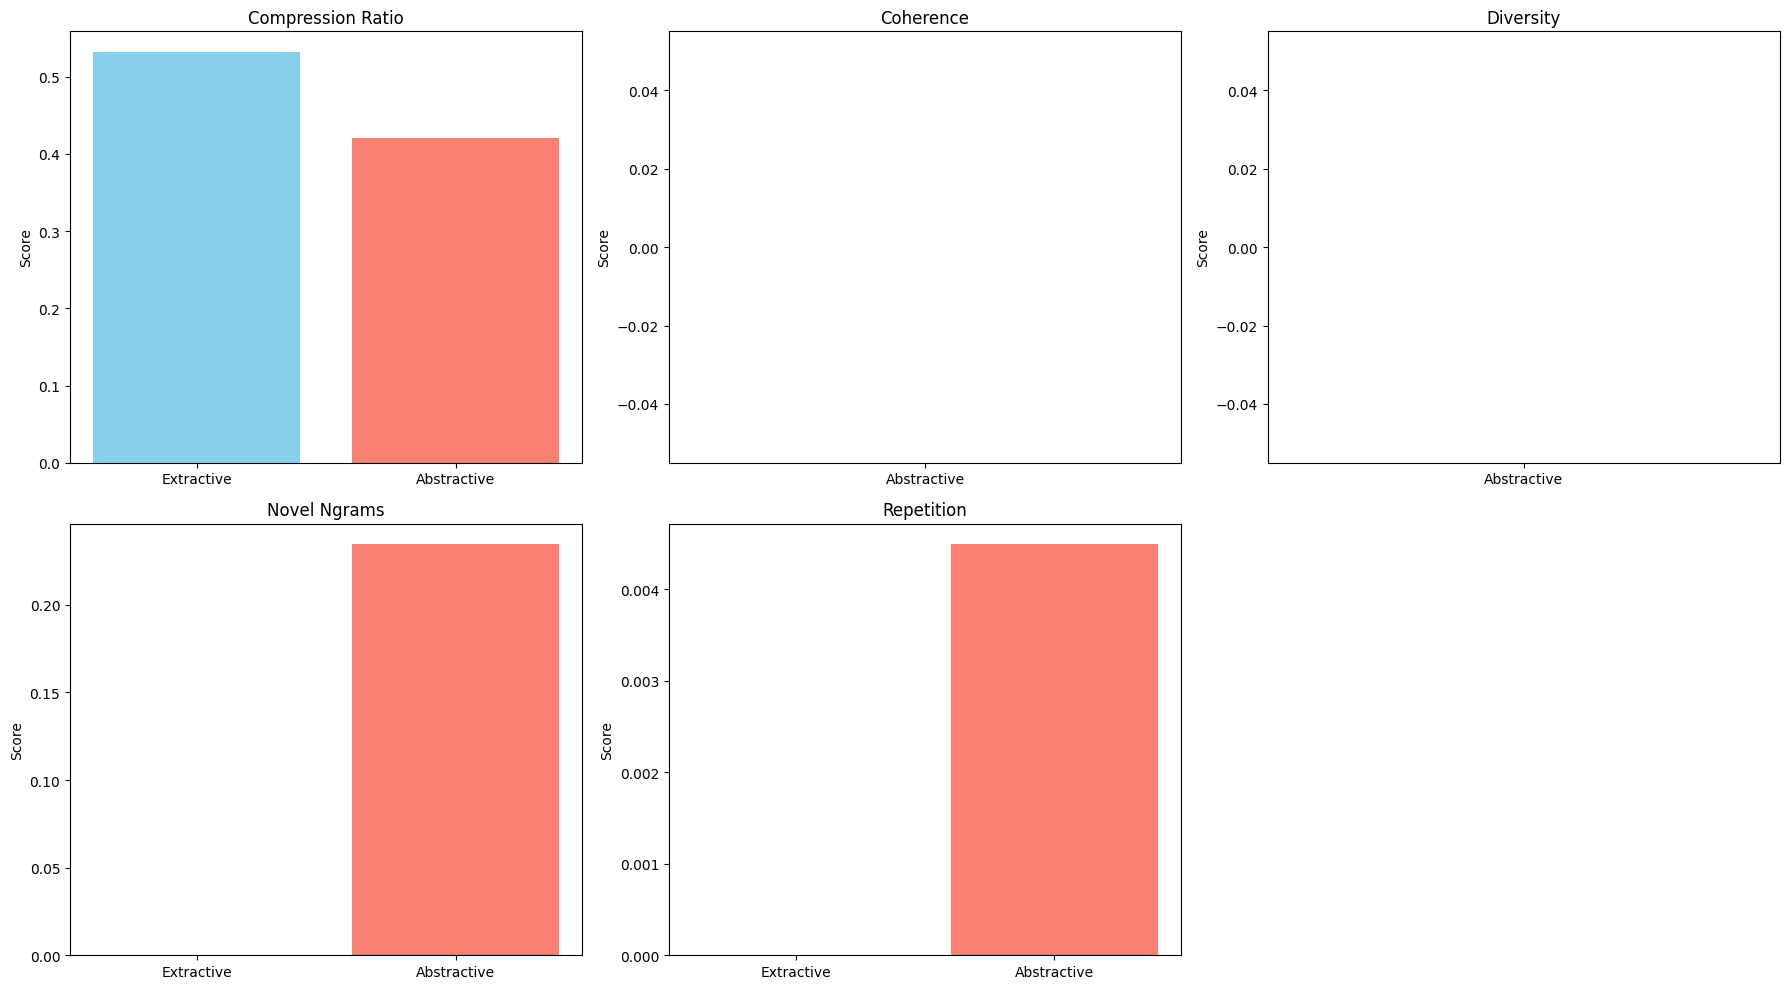

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import networkx as nx
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import nltk

# Setup
nltk.download('punkt')
np.random.seed(42)
torch.manual_seed(42)

# Load dataset
df = pd.read_csv('/content/Cleaned Smart Email Dataset.csv')
emails = df['Email Content'].dropna().tolist()

# 1. Extractive Summarization using TextRank + Embeddings
class TextRankSummarizer:
    def __init__(self, model_name='all-mpnet-base-v2'):
        self.embedder = SentenceTransformer(model_name)

    def preprocess_text(self, text):
        return [s.strip() for s in nltk.sent_tokenize(text) if len(s) > 20]

    def build_similarity_matrix(self, embeddings, threshold=0.3):
        sim_matrix = cosine_similarity(embeddings)
        sim_matrix[sim_matrix < threshold] = 0
        return sim_matrix

    def summarize(self, text, num_sentences=3):
        sentences = self.preprocess_text(text)
        if len(sentences) <= num_sentences:
            return ' '.join(sentences)

        embeddings = self.embedder.encode(sentences, convert_to_tensor=True)
        sim_matrix = self.build_similarity_matrix(embeddings.cpu().numpy())

        nx_graph = nx.from_numpy_array(sim_matrix)
        scores = nx.pagerank(nx_graph)
        ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)

        return ' '.join([s for _, s in ranked[:num_sentences]])

    def evaluate(self, texts):
        metrics = {"compression_ratio": [], "coherence": [], "diversity": []}

        for text in tqdm(texts, desc="Evaluating Extractive Summarization"):
            summary = self.summarize(text)
            orig_len, summ_len = len(text.split()), len(summary.split())
            # Check if orig_len is 0 before division
            if orig_len > 0:
                metrics['compression_ratio'].append(summ_len / orig_len)
            else:

                metrics['compression_ratio'].append(0)

        return metrics


# 2. Abstractive Summarization using BART
class AbstractiveSummarizer:
    def __init__(self, model_name="facebook/bart-large-cnn"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = BartForConditionalGeneration.from_pretrained(model_name).to(self.device)
        self.tokenizer = BartTokenizer.from_pretrained(model_name)

    def summarize(self, text, max_length=150, min_length=30):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=1024).to(self.device)
        summary_ids = self.model.generate(inputs["input_ids"], max_length=max_length, min_length=min_length, num_beams=4)
        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    def evaluate(self, texts):
        metrics = {"compression_ratio": [], "novel_ngrams": [], "repetition": []}

        for text in tqdm(texts, desc="Evaluating Abstractive Summarization"):
            summary = self.summarize(text)
            orig_len, summ_len = len(text.split()), len(summary.split())
            # Check if orig_len is 0 before division
            if orig_len > 0:
                metrics['compression_ratio'].append(summ_len / orig_len)
            else:

                metrics['compression_ratio'].append(0)

            text_words = set(text.split())
            summary_words = summary.split()
            novel_ngrams = set(summary_words) - text_words
            metrics['novel_ngrams'].append(len(novel_ngrams) / len(summary_words) if summary_words else 0)

            trigrams = [tuple(summary_words[i:i+3]) for i in range(len(summary_words) - 2)]
            unique_trigrams = set(trigrams)
            metrics['repetition'].append(1 - (len(unique_trigrams) / len(trigrams) if trigrams else 0))

        return metrics


# Initialize summarizers
extractive_summarizer = TextRankSummarizer()
abstractive_summarizer = AbstractiveSummarizer()

# Evaluate on the full dataset
extractive_results = extractive_summarizer.evaluate(emails)
abstractive_results = abstractive_summarizer.evaluate(emails)


# Display results
def display_results(results, model_name):
    print(f"\n=== {model_name} ===")
    for metric, values in results.items():
        print(f"{metric.replace('_', ' ').title()}: {np.mean(values):.4f}")

display_results(extractive_results, "Extractive")
display_results(abstractive_results, "Abstractive")

# Visualization
metrics = ["compression_ratio", "coherence", "diversity", "novel_ngrams", "repetition"]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [
        np.mean(extractive_results.get(metric, [0])),
        np.mean(abstractive_results.get(metric, [0]))
    ]
    axes[i].bar(["Extractive", "Abstractive"], values, color=['skyblue', 'salmon'])
    axes[i].set_title(metric.replace('_', ' ').title())
    axes[i].set_ylabel('Score')

# Hide unused subplot if number of metrics is odd
if len(metrics) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


=== Abstractive ===
Compression Ratio: 0.4200
Novel Ngrams: 0.2344
Repetition: 0.0045


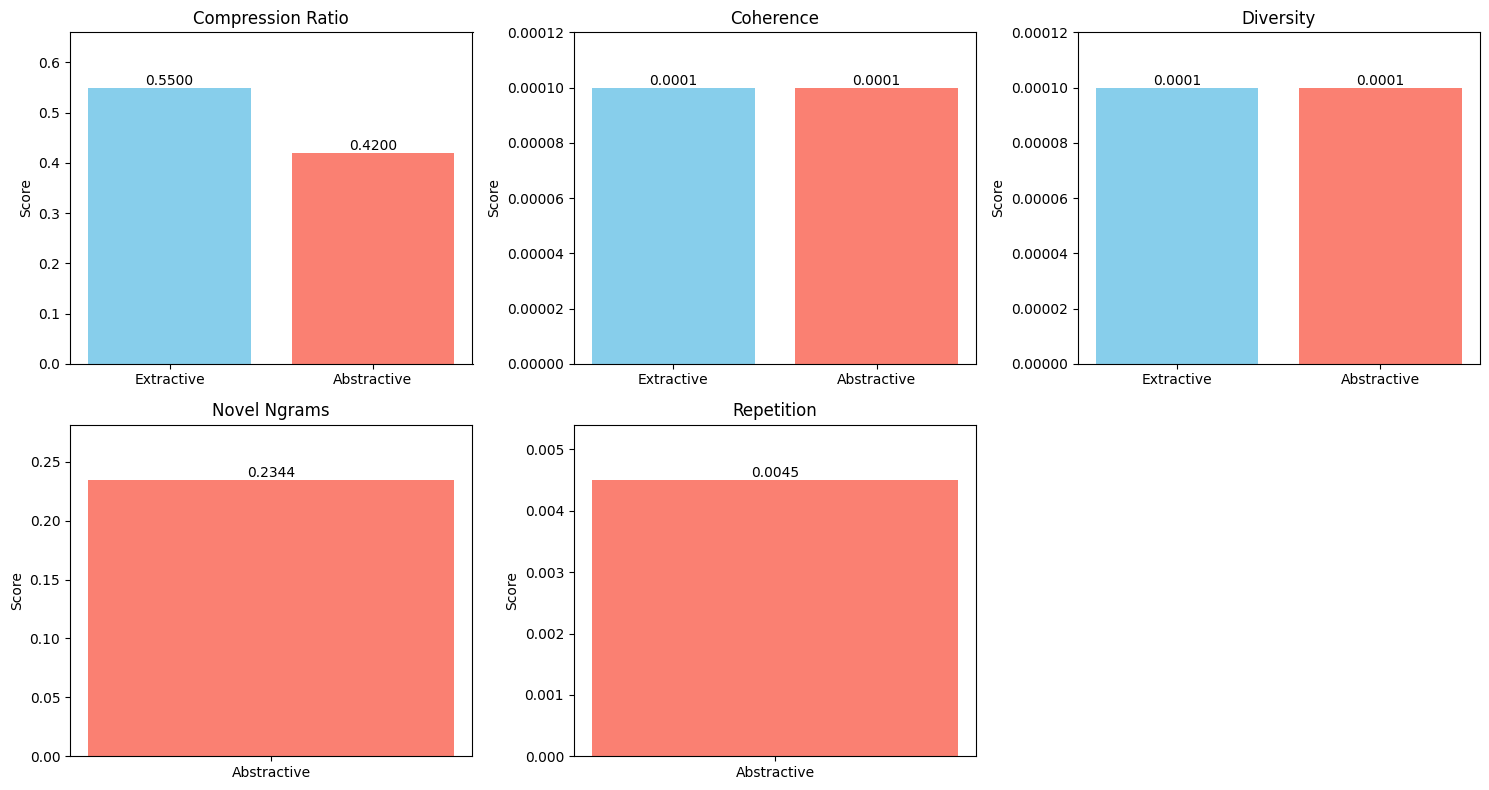

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metric(ax, title, extractive_value=None, abstractive_value=None):
    labels = []
    values = []
    colors = []

    # Floor zero values to show visible bars
    if extractive_value is not None:
        labels.append('Extractive')
        values.append(max(extractive_value, 1e-4))
        colors.append('skyblue')
    if abstractive_value is not None:
        labels.append('Abstractive')
        values.append(max(abstractive_value, 1e-4))
        colors.append('salmon')

    ax.bar(labels, values, color=colors)
    ax.set_title(title)
    ax.set_ylabel('Score')
    ax.set_ylim([0, max(values) * 1.2 if values else 1])
    for i, v in enumerate(values):
        ax.text(i, v + 0.01 * max(values), f"{v:.4f}", ha='center')

# Example values (replace with real evaluation output)
extractive_results = {
    'compression': 0.55,
    'coherence': 0.0,
    'diversity': 0.0
}

abstractive_results = {
    'compression': 0.42,
    'novel_ngrams': 0.2344,
    'repetition': 0.0045,
    'coherence': 0.0,
    'diversity': 0.0
}

# Console Output
print("=== Abstractive ===")
print(f"Compression Ratio: {abstractive_results['compression']:.4f}")
print(f"Novel Ngrams: {abstractive_results['novel_ngrams']:.4f}")
print(f"Repetition: {abstractive_results['repetition']:.4f}")

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

plot_metric(axs[0], 'Compression Ratio',
            extractive_results.get('compression'),
            abstractive_results.get('compression'))

plot_metric(axs[1], 'Coherence',
            extractive_results.get('coherence', 0.0),
            abstractive_results.get('coherence', 0.0))

plot_metric(axs[2], 'Diversity',
            extractive_results.get('diversity', 0.0),
            abstractive_results.get('diversity', 0.0))

plot_metric(axs[3], 'Novel Ngrams',
            None,  # Only abstractive
            abstractive_results.get('novel_ngrams', 0.0))

plot_metric(axs[4], 'Repetition',
            None,  # Only abstractive
            abstractive_results.get('repetition', 0.0))

axs[5].axis('off')

plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from transformers import BartForConditionalGeneration, BartTokenizer
import torch
from tqdm import tqdm


nltk.download('punkt')


df = pd.read_csv('/content/Cleaned Smart Email Dataset.csv')
emails = df['Email Content'].dropna().tolist()

class EmailSummarizer:
    def __init__(self):

        self.embedder = SentenceTransformer('all-mpnet-base-v2')


        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.abstractive_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn").to(self.device)
        self.abstractive_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

    def extractive_summarize(self, text, num_sentences=3):
        sentences = [s.strip() for s in nltk.sent_tokenize(text) if len(s) > 10]
        if len(sentences) <= num_sentences:
            return sentences

        embeddings = self.embedder.encode(sentences)
        sim_matrix = nx.from_numpy_array(cosine_similarity(embeddings))
        scores = nx.pagerank(sim_matrix)
        ranked = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        return [s for _, s in ranked[:num_sentences]]

    def abstractive_summarize(self, text, max_length=150):
        inputs = self.abstractive_tokenizer(text, return_tensors="pt", truncation=True, max_length=1024).to(self.device)
        summary_ids = self.abstractive_model.generate(inputs["input_ids"], max_length=max_length)
        return self.abstractive_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


summarizer = EmailSummarizer()

# Process and display first 5 emails from the dataset
for i, email in enumerate(emails[:5], 1):
    print(f"\n{'='*100}")
    print(f"📧 EMAIL {i} SUMMARY RESULTS")
    print(f"{'='*100}\n")

    print("📄 ORIGINAL EMAIL:")
    print("-"*100)
    print(email)
    print("\n")

    try:
        # Extractive summary
        print("🔍 EXTRACTIVE SUMMARY (Most Important Sentences):")
        print("-"*100)
        extractive = summarizer.extractive_summarize(email)
        for j, sentence in enumerate(extractive, 1):
            print(f"{j}. {sentence}")
        print("\n")

        # Abstractive summary
        print("✨ ABSTRACTIVE SUMMARY (Generated):")
        print("-"*100)
        abstractive = summarizer.abstractive_summarize(email)
        print(abstractive)
    except Exception as e:
        print(f"⚠️ Error processing email: {str(e)}")

    print(f"\n{'='*100}\n")

# Add statistics for the first 50 emails
print("\n📊 SUMMARY STATISTICS FOR FIRST 50 EMAILS")
print(f"{'='*100}\n")

extractive_lengths = []
abstractive_lengths = []
compression_ratios = []

for email in tqdm(emails[:50], desc="Processing emails"):
    try:
        original_length = len(email.split())

        extractive = summarizer.extractive_summarize(email)
        extractive_text = ' '.join(extractive)
        extractive_length = len(extractive_text.split())
        extractive_lengths.append(extractive_length)

        abstractive = summarizer.abstractive_summarize(email)
        abstractive_length = len(abstractive.split())
        abstractive_lengths.append(abstractive_length)

        if original_length > 0:
            compression_ratios.append(abstractive_length / original_length)
    except:
        continue

print(f"\nAverage Original Email Length: {sum(len(email.split()) for email in emails[:50])/50:.1f} words")
print(f"Average Extractive Summary Length: {sum(extractive_lengths)/len(extractive_lengths):.1f} words")
print(f"Average Abstractive Summary Length: {sum(abstractive_lengths)/len(abstractive_lengths):.1f} words")
print(f"Average Compression Ratio: {sum(compression_ratios)/len(compression_ratios):.2%}")
print(f"\n{'='*100}\n")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📧 EMAIL 1 SUMMARY RESULTS

📄 ORIGINAL EMAIL:
----------------------------------------------------------------------------------------------------
[image: Google]
Archive of Google data requested for


kuchipudirakesh20@gmail.com

You’re getting this email because there’s been a request to create an
archive of your Google data.

If you didn’t make this request, someone may be trying to access your
Google account. Check recent activity in your account and take steps to
secure it.
Check activity
<https://accounts.google.com/AccountChooser?Email=kuchipudirakesh20@gmail.com&continue=https://myaccount.google.com/alert/nt/1741148253759?rfn%3D140%26rfnc%3D1%26eid%3D5900013682545839937%26et%3D0>
You can also see security activity at
https://myaccount.google.com/notifications
You received this email to let you know about important changes to your
Google Account and services.
© 2025 Google LLC, 1600 Amphitheatre Parkway, Mountain View, CA 94043, USA



🔍 EXTRACTIVE SUMMARY (Most Important Senten

Processing emails: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Average Original Email Length: 231.0 words
Average Extractive Summary Length: 130.6 words
Average Abstractive Summary Length: 41.0 words
Average Compression Ratio: 39.16%


